# Overview

## Audience

This notebook is designed for a technical persona that has familarity with large language models (LLMs).  It is preferred, but not required, that the audience is familiar with using [LangChain](https://www.langchain.com/) and the RAG pattern. 

## Retrieval-Augmented Generation

[Retrieval-augmented generation](https://research.ibm.com/blog/retrieval-augmented-generation-RAG), or RAG, is an architectural pattern for improving the generated responses from large language models (LLM).  It does this by *augmented* queries to the LLM with additional context.

A basic LLM generation takes the query as is, or with some prompt engineering (e.g. prompt template, meta-prompting, chain-of-thought prompting, etc).

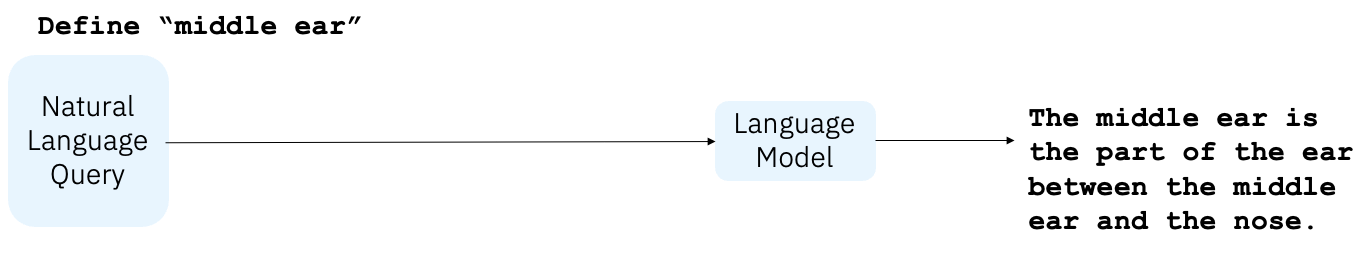

With RAG, the query is augmented with relevant knowledge from a knowledge base of some sort.  This additional revelant knowledge (context) helps the LLM generation by:
1. Reducing hallucinations with a grounding set of external, verifiable information
2. Providing information it may have otherwise not have had access to (i.e. data not available at the time of training).  For example, more up-to-date data than that available at training time, or private (e.g confidential, proprietary) data.

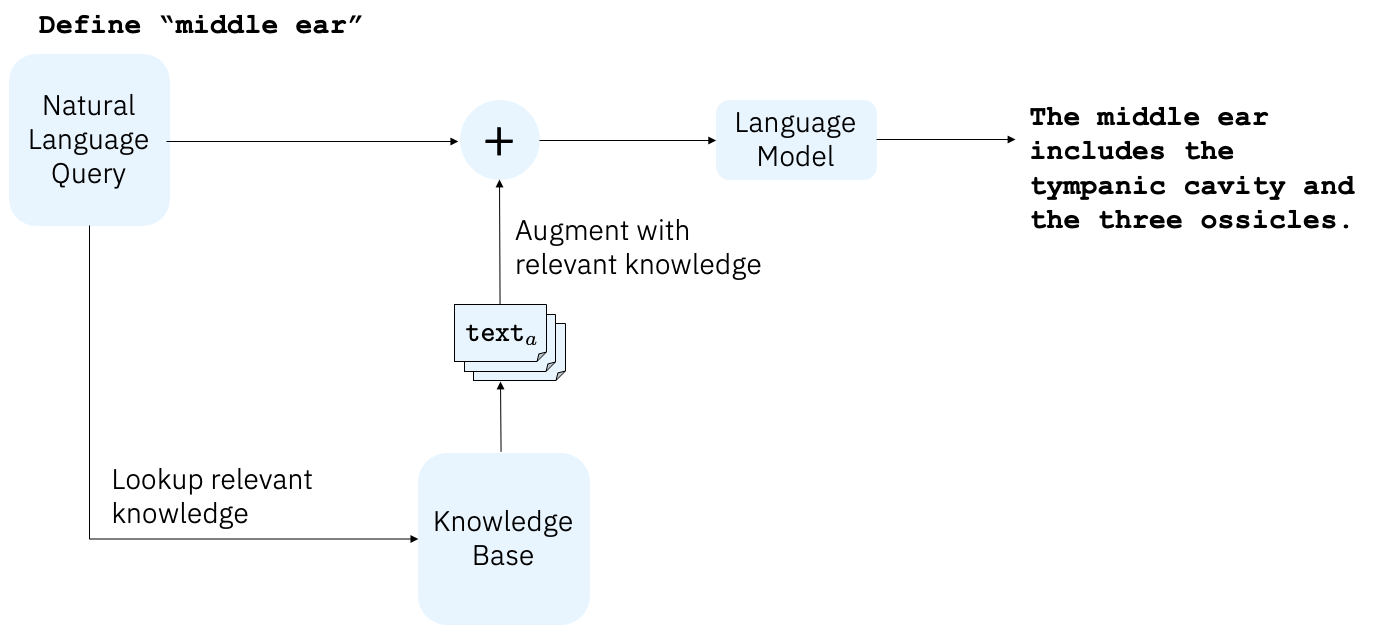

Furthermore, the additional relevant knowledge can provide some *explanability* to the LLM output by providing a cross-referenceable set of information (i.e. the relevant text) you can examine to see what the LLM is basing its answer on.

For the interested reader, here is the original RAG paper: [Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks](https://arxiv.org/abs/2005.11401)

A common implementation of the knowledge base is a vector store (or vector database).  A vector store can inefficient index and search across vectors.  With this implementation, a corpus of knowledge (as text) is stored as vectors know as *embeddings*.  [Embeddings](https://huggingface.co/blog/getting-started-with-embeddings) are not just arbitrary numerical representations of text.  Instead, the representation captures the semantic meaning of what is being embedded.  In other words, a collection of text that are semantically similar to each other will also be mathametical close to each in vector space.  An embedding model converts a chunk of text into its embedding representation.

The following figure is a conceptual illustration of the RAG pattern implemented with a vector store.  The encode and decode blocks are embedding models and embedding-to-source text lookup, respectively.

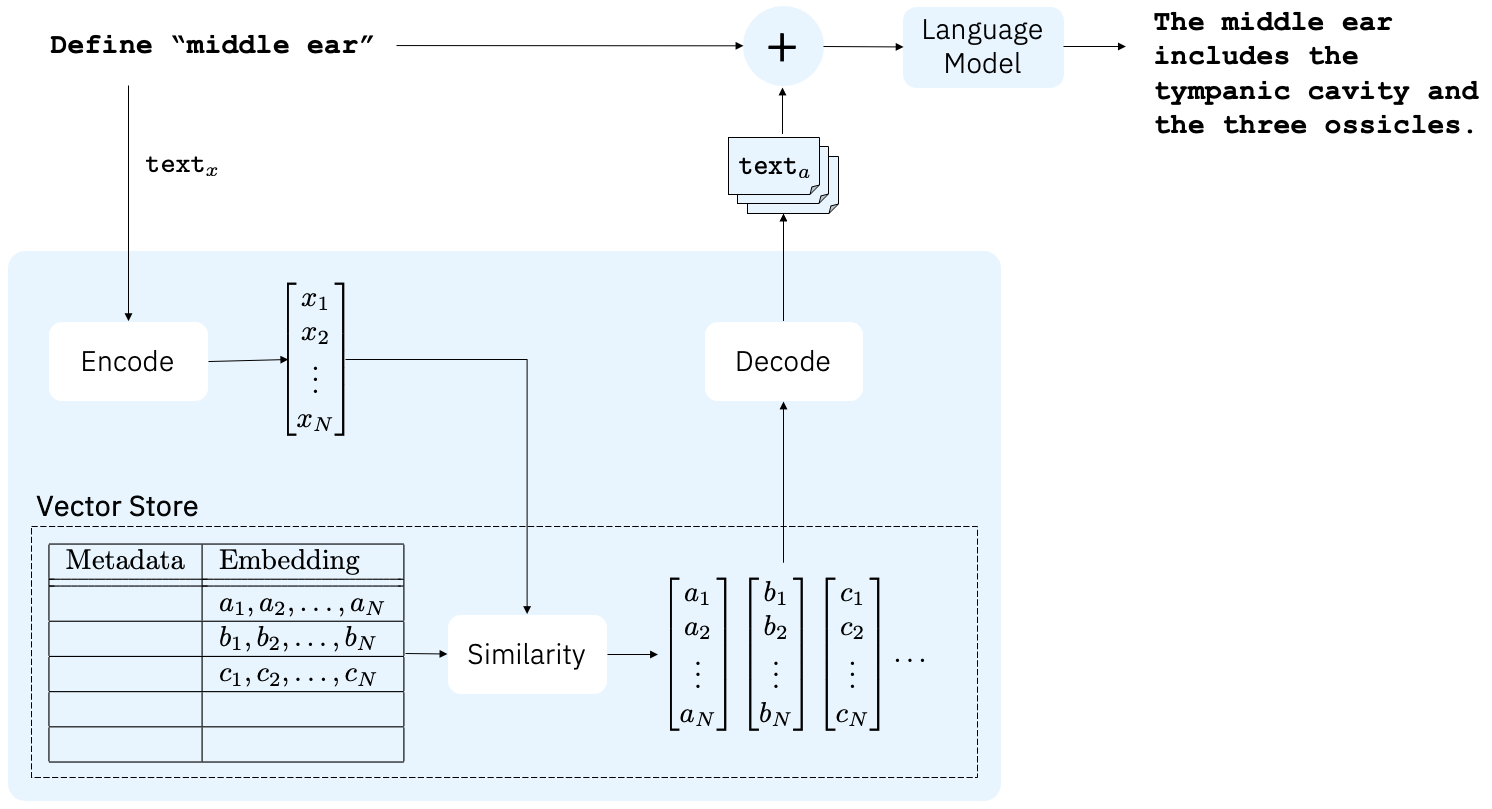

## Notebook Outline

Here's an outline of this notebook.

* [Setup and Configuration section](#setup-and-configuration).  We ensure all the required packages are installed and the configuration information (e.g. credentials) are provided.

* [Define Query section](#query).  We establish the query to be used.  This is established up front because we will use the same query in a basic completion with use an LLM and with a RAG pattern.

* [Initialize Language Model section](#language-model).  We select and configure the large language model (LLM).

* [Perform Basic Completion section](#basic-completion).  We perform a basic completion with our query and LLM.

* [Get Data for Documents section](#data).  We get and preprocess (e.g. split) the data we want to use in our knowledge base.

* [Initialize Embedding Model section](#embeddings).  We select and configure the embedding model we would like to use to encode our data for our knowledge base.

* [Initialize Vector Store section](#vector-store).  We initialize our vector store with our data and embedding model.

* [Perform Similiarity Search section](#similarity-search).  We use our initialized vector store and perform a similiarity search with our query.

* [Perform RAG Generation section](#rag-generation).  We perform a completion with a RAG pipeline.  In this version, we are explicitly passing the relevant docs (from our similarity search).

* [Perform RAG Generation with Q&A Chain Section](#rag-qa-chain).  We perform a completion with a RAG pipeline.  In this version, there is no explicit passing of relevant docs.

# Setup and Configuration
<a id="setup-and-configuration"></a>

## Set Dev Settings

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Install Packages

In [2]:
!pip install langchain -q
!pip install ibm-watson-machine-learning -q
!pip install wget -q
!pip install sentence-transformers -q

* `langchain`: Orchestration framework
* `ibm-watson-machine-learning`: For IBM LLMs
* `wget`: To download knowledge base data
* `sentence-transformers`: For embedding model

In [3]:
!pip install singlestoredb -q
!pip install sqlalchemy-singlestoredb -q

## Import Utility Packages

In [4]:
import os
import getpass

## Get Environment Variables and Keys

### Get watsonx URL

In [5]:
try:
    wxa_url = os.environ["WXA_URL"]
except KeyError:
    wxa_url = getpass.getpass("Please enter your watsonx.ai URL domain (hit enter): ")

### Get watsonx API Key

In [6]:
try:
    wxa_api_key = os.environ["WXA_API_KEY"]
except KeyError:
    wxa_api_key = getpass.getpass("Please enter your watsonx.ai API key (hit enter): ")

### Get watsonx Project ID

In [7]:
try:
    wxa_project_id = os.environ["WXA_PROJECT_ID"]
except KeyError:
    wxa_project_id = getpass.getpass("Please enter your watsonx.ai Project ID (hit enter): ")

### Get SingleStoreDB credentials and configuration

If you do not have a SingleStoreDB instance, you can start today with a free trial [here](https://www.singlestore.com/cloud-trial/).
To get the connection strings:
* Select a **workspace**
* If the workspace is suspended, click on **resume** it
* Click on **Connect**
* Click on **Connect Directly**
* Click **SQL IDE** which gives you SINGLESTORE_USER (**admin** for trials), SINGLESTORE_PASS (Password), SINGLESTORE_PORT (usually **3306**)
* Pick a name for your SINGLESTORE_DATABASE

In [8]:
try:
    connection_user = os.environ["SINGLESTORE_USER"]
except KeyError:
    connection_user = getpass.getpass("Please enter your SingleStore username (hit enter): ")

In [9]:
try:
    connection_password = os.environ["SINGLESTORE_PASS"]
except KeyError:
    connection_password = getpass.getpass("Please enter your SingleStore password (hit enter): ")

In [10]:
try:
    connection_port = os.environ["SINGLESTORE_PORT"]
except KeyError:
    database_name = input("Please enter your SingleStore database name (hit enter): ")

In [11]:
try:
    connection_host = os.environ["SINGLESTORE_HOST"]
except KeyError:
    database_name = input("Please enter your SingleStore database name (hit enter): ")

In [12]:
try:
    database_name = os.environ["SINGLESTORE_DATABASE"]
except KeyError:
    database_name = input("Please enter your SingleStore database name (hit enter): ")

In [13]:
try:
    table_name = os.environ["SINGLESTORE_TABLE"]
except KeyError:
    table_name = input("Please enter your SingleStore table name (hit enter): ")

# Define Query
<a id="query"></a>

In [14]:
query = "What did the president say about Ketanji Brown Jackson?"

# Initialize Language Model
<a id="language-model"></a>

For our language model, we will use [Granite](https://www.ibm.com/downloads/cas/X9W4O6BM), an IBM developed LLM.

In [15]:
from ibm_watson_machine_learning.foundation_models.utils.enums import ModelTypes
from ibm_watson_machine_learning.foundation_models import Model
from ibm_watson_machine_learning.metanames import GenTextParamsMetaNames as GenParams
from ibm_watson_machine_learning.foundation_models.utils.enums import DecodingMethods

In [16]:
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.GREEDY,
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.MAX_NEW_TOKENS: 100
}

In [17]:
model = Model(
    model_id=ModelTypes.GRANITE_13B_CHAT,
    params=parameters,
    credentials={
        "url": wxa_url,
        "apikey": wxa_api_key
    },
    project_id=wxa_project_id
)

In [18]:
from ibm_watson_machine_learning.foundation_models.extensions.langchain import WatsonxLLM
granite_llm_ibm = WatsonxLLM(model=model)

# Perform Basic Completion
<a id="basic-completion"></a>

In [19]:
response = granite_llm_ibm(query)

In [20]:
print("Query: " + query)
print("Response: " + response)

Query: What did the president say about Ketanji Brown Jackson?
Response: 
The president said that Ketanji Brown Jackson is an “incredible judge” and that he is “proud” to have nominated her to the Supreme Court.<|endoftext|>


# Get Data for Documents
<a id="data"></a>

## Download Data

In [21]:
import wget

filename = './state_of_the_union.txt'
url = 'https://raw.github.com/IBM/watson-machine-learning-samples/master/cloud/data/foundation_models/state_of_the_union.txt'

In [22]:
if not os.path.isfile(filename):
    wget.download(url, out=filename)

## Load Documents

In [23]:
from langchain.document_loaders import TextLoader

loader = TextLoader(filename)
documents = loader.load()

## Split Documents

In [24]:
from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

In [25]:
print("We split our document into " + str(len(texts)) + " chunks.")

We split our document into 42 chunks.


# Initialize Embedding Model

We will be using default [LangChain Hugging Face embedding model](https://python.langchain.com/docs/integrations/platforms/huggingface/#embedding-models), which at the time of this writing is [sentence-transformers/all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2).

In [26]:
from langchain.embeddings import HuggingFaceEmbeddings
embedding_model = HuggingFaceEmbeddings()

# Initialize Vector Store
<a id="vector-store"></a>

## Create a SingleStore SQLAlchemy Engine

In [27]:
from sqlalchemy import *

In [28]:
connection_url = f"singlestoredb://{connection_user}:{connection_password}@{connection_host}:{connection_port}"
engine = create_engine(connection_url)

## Create Database for Embeddings if Doesn't Exist

In [29]:
with engine.connect() as conn:
    result = conn.execute(text("CREATE DATABASE IF NOT EXISTS " + database_name))

In [30]:
# Verify that the database was created
print("Available databases:")
with engine.connect() as conn:
    result = conn.execute(text("SHOW DATABASES"))
    for row in result:
        print(row)

Available databases:
('cluster',)
('information_schema',)
('memsql',)
('movie_recommender',)
('movie_recommender2',)
('resume_evaluator',)
('tpch_optimized',)
('watsonx_ibm',)


## Drop Table for Embedings if Exist

In [31]:
with engine.connect() as conn:
    result = conn.execute(text("DROP TABLE IF EXISTS " + database_name + "." + table_name))

## Instantiate SingleStoreDB in LangChain

In [32]:
# Connection string to use Langchain with SingleStoreDB
os.environ["SINGLESTOREDB_URL"] = f"{connection_user}:{connection_password}@{connection_host}:{connection_port}/{database_name}"

In [33]:
from langchain.vectorstores import SingleStoreDB
vectorstore = SingleStoreDB.from_documents(
        texts,
        embedding_model,
        table_name = table_name
)

## Check Table

In [34]:
with engine.connect() as conn:
    result = conn.execute(text("DESCRIBE " + database_name + "." + table_name))
    print(database_name + "." + table_name + " table schema:")
    for row in result:
        print(row)

    result = conn.execute(text("SELECT COUNT(vector) FROM " + database_name + "." + table_name))
    print("\nNumber of rows in " + database_name + "." + table_name + ": " + str(result.first()[0]))

watsonx_ibm.docs_embeddings table schema:
('content', 'text', 'YES', '', None, '')
('vector', 'blob', 'YES', '', None, '')
('metadata', 'JSON', 'YES', '', None, '')

Number of rows in watsonx_ibm.docs_embeddings: 42


# Perform Similiarity Search
<a id="similarity-search"></a>

We find the similar (i.e. relevant) texts to our query.  You can modify the number of results returned with `k` parameter in the `similarity_search` method below.

In [35]:
texts_sim = vectorstore.similarity_search(query, k=5)

In [36]:
print("Number of relevant texts: " + str(len(texts_sim)))

Number of relevant texts: 5


In [37]:
print("First 100 characters of relevant texts.")
for i in range(len(texts_sim)):
        print("Text " + str(i+1) + ": " + str(texts_sim[i].page_content[0:100]))

First 100 characters of relevant texts.
Text 1: Tonight. I call on the Senate to: Pass the Freedom to Vote Act. Pass the John Lewis Voting Rights Ac
Text 2: A former top litigator in private practice. A former federal public defender. And from a family of p
Text 3: As Frances Haugen, who is here with us tonight, has shown, we must hold social media platforms accou
Text 4: And I’m taking robust action to make sure the pain of our sanctions  is targeted at Russia’s economy
Text 5: But cancer from prolonged exposure to burn pits ravaged Heath’s lungs and body. 

Danielle says Heat


# Perform RAG Generation with Explicit Context Control
<a id="rag-explicit"></a>

RAG generation using our [model](#language-model) and explicit relevant knowledge (documents) from our [similarity search](#similarity-search).

In [38]:
from langchain.chains.question_answering import load_qa_chain
chain = load_qa_chain(granite_llm_ibm, chain_type="stuff")
response = chain.run(input_documents=texts_sim, question=query)

In [39]:
print("Query: " + query)
print("Response:" + response)

Query: What did the president say about Ketanji Brown Jackson?
Response: The president said that Ketanji Brown Jackson is a consensus builder who will continue Justice Breyer's legacy of excellence.<|endoftext|>


# Perform RAG Generation with Q&A Chain
<a id="rag-qa-chain"></a>

RAG generation using a chain of our [model](#language-model) and [vector store](#vector-store).  The chain handles getting the relevant knowledge (texts) under the hood.

In [40]:
from langchain.chains import RetrievalQA
qa = RetrievalQA.from_chain_type(llm=granite_llm_ibm, chain_type="stuff", retriever=vectorstore.as_retriever())
response = qa.run(query)

In [41]:
print("Query: " + query)
print("Response:" + response)

Query: What did the president say about Ketanji Brown Jackson?
Response: The president said that Ketanji Brown Jackson is a consensus builder who will continue Justice Breyer's legacy of excellence.<|endoftext|>


# <hr>
Copyright © 2023 IBM. This notebook and its source code are released under the terms of the MIT License.